In [2]:
import tensorflow as tf

'2.8.0'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
df = pd.read_csv('C:/Users/helva/plant-pathology/train.csv', index_col=0)
print(df.shape)
df.head()

(1821, 4)


,healthy,multiple_diseases,rust,scab
image_id,,,,
Train_0,0,0,0,1
Train_1,0,1,0,0
Train_2,1,0,0,0
Train_3,0,0,1,0
Train_4,1,0,0,0


In [7]:
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

print(train_set.shape)
print(valid_set.shape)

(1456, 4)
(365, 4)


In [10]:
import shutil
from shutil import copyfile

# delete temp dir
if os.path.exists('/kaggle/temp/'):
    shutil.rmtree('/kaggle/temp/')

# train directory
os.mkdir('C:/Users/helva/train')
os.mkdir('C:/Users/helva/train/healthy')
os.mkdir('C:/Users/helva/train/multiple_diseases')
os.mkdir('C:/Users/helva/train/rust')
os.mkdir('C:/Users/helva/train/scab')

# validation directory
os.mkdir('C:/Users/helva/valid')
os.mkdir('C:/Users/helva/valid/healthy')
os.mkdir('C:/Users/helva/valid/multiple_diseases')
os.mkdir('C:/Users/helva/valid/rust')
os.mkdir('C:/Users/helva/valid/scab')

In [11]:
SOURCE = 'C:/Users/helva/plant-pathology/images/'

TRAIN_DIR = 'C:/Users/helva/train/'

for index, data in train_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(TRAIN_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(TRAIN_DIR):
    print(subdir, len(os.listdir(os.path.join(TRAIN_DIR, subdir))))

healthy 416
multiple_diseases 73
rust 502
scab 465


In [12]:
VALID_DIR = 'C:/Users/helva/valid/'

# copy images to valid directory
for index, data in valid_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(VALID_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(VALID_DIR):
    print(subdir, len(os.listdir(os.path.join(VALID_DIR, subdir))))

healthy 100
multiple_diseases 18
rust 120
scab 127


In [13]:
healthy_dir = os.path.join(TRAIN_DIR, 'healthy')
mdiseases_dir = os.path.join(TRAIN_DIR, 'multiple_diseases')
scab_dir = os.path.join(TRAIN_DIR, 'scab')
rust_dir = os.path.join(TRAIN_DIR, 'rust')

healthy_files = os.listdir(healthy_dir)
mdiseases_files = os.listdir(mdiseases_dir)
scab_files = os.listdir(scab_dir)
rust_files = os.listdir(rust_dir) 

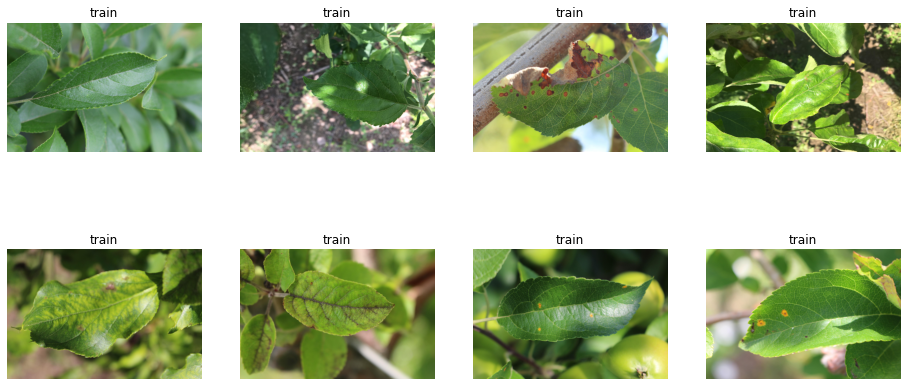

In [15]:
%matplotlib inline

import matplotlib.image as mpimg

pic_index = 2

next_healthy = [os.path.join(healthy_dir, fname) for fname in healthy_files[pic_index-2:pic_index]]
next_mdiseases = [os.path.join(mdiseases_dir, fname) for fname in mdiseases_files[pic_index-2:pic_index]]
next_scab = [os.path.join(scab_dir, fname) for fname in scab_files[pic_index-2:pic_index]]
next_rust = [os.path.join(rust_dir, fname) for fname in rust_files[pic_index-2:pic_index]]


nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(next_healthy+next_mdiseases+next_scab+next_rust):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.title(img_path.split('/')[-2])
    plt.imshow(img)
    
plt.show()

In [16]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)
validation_generator = validation_datagen.flow_from_directory(VALID_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)

Found 1456 images belonging to 4 classes.
Found 365 images belonging to 4 classes.


In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [26]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn.h5", save_best_only=True)

history = model.fit(train_generator, epochs=50, steps_per_epoch=46, 
                    validation_data = validation_generator, validation_steps=12)

Epoch 1/50
46/46 [==============================] - 78s 2s/step - loss: 0.9030 - accuracy: 0.6875 - val_loss: 0.5985 - val_accuracy: 0.7507
Epoch 2/50
46/46 [==============================] - 74s 2s/step - loss: 0.6835 - accuracy: 0.7136 - val_loss: 0.8536 - val_accuracy: 0.6822
Epoch 3/50
46/46 [==============================] - 79s 2s/step - loss: 0.7167 - accuracy: 0.7150 - val_loss: 0.6211 - val_accuracy: 0.7644
Epoch 4/50
46/46 [==============================] - 77s 2s/step - loss: 0.6683 - accuracy: 0.7260 - val_loss: 0.6368 - val_accuracy: 0.7370
Epoch 5/50
46/46 [==============================] - 77s 2s/step - loss: 0.6271 - accuracy: 0.7452 - val_loss: 0.7753 - val_accuracy: 0.6493
Epoch 6/50
46/46 [==============================] - 77s 2s/step - loss: 0.5950 - accuracy: 0.7617 - val_loss: 0.5229 - val_accuracy: 0.8082
Epoch 7/50
46/46 [==============================] - 79s 2s/step - loss: 0.5985 - accuracy: 0.7672 - val_loss: 0.7053 - val_accuracy: 0.6877
Epoch 8/50
46/46 [==

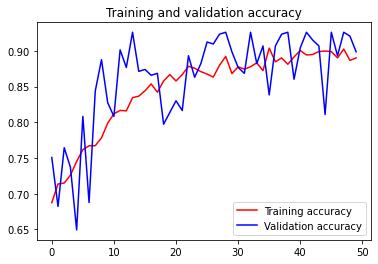

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [29]:
model = tf.keras.models.load_model("cnn.h5")
model.evaluate(validation_generator)

12/12 [==============================] - 11s 894ms/step - loss: 0.6117 - accuracy: 0.7178


[0.6116930246353149, 0.7178082466125488]

In [30]:
from keras_preprocessing import image

test_set = pd.read_csv("C:/Users/helva/plant-pathology/test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test) / 255

In [31]:
y_pred = model.predict(X_test, batch_size=10)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(y_pred, columns = train_generator.class_indices.keys())], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

,healthy,multiple_diseases,rust,scab
image_id,,,,
Test_0,4.991026e-07,0.001778,0.998222,5.801162e-08
Test_1,4.909891e-04,0.037418,0.962018,7.307223e-05
Test_2,5.185638e-01,0.025039,0.032128,4.242687e-01
Test_3,5.856797e-01,0.020833,0.030500,3.629870e-01
Test_4,3.809605e-19,0.000008,0.999992,6.288978e-21


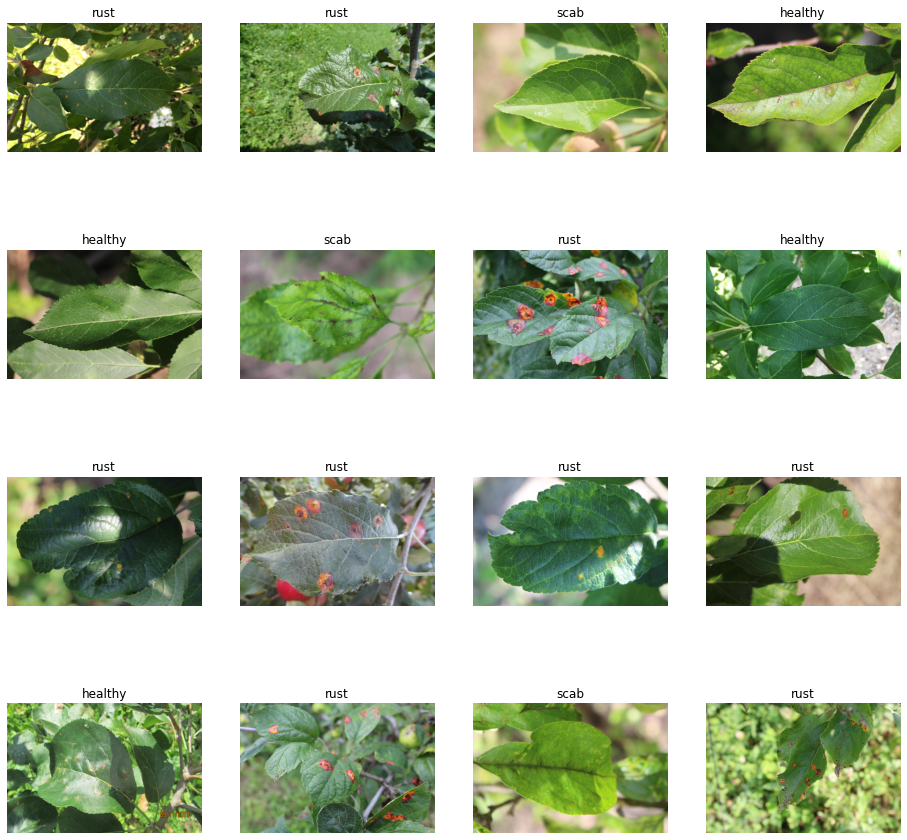

In [32]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, (idx, row) in enumerate(df_out.sample(nrows*ncols).iterrows()):
    filepath = filepath = os.path.join(SOURCE, idx + ".jpg")
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(filepath)
    plt.title(df_out.columns[np.argmax(row)])
    plt.imshow(img)
    
plt.show()